In [1]:
!pip install torch torchvision scikit-image opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
from google.colab import files
import os

uploaded = files.upload()
os.makedirs("images", exist_ok=True)

for fname in uploaded:
    os.rename(fname, f"images/{fname}")


Saving cascade-boat-clean-china-natural-rural_1417-1356.avif to cascade-boat-clean-china-natural-rural_1417-1356.avif
Saving download.jpeg to download.jpeg
Saving har.jpg to har.jpg


In [4]:
import torch
import torch.nn as nn

class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
        )

    def forward(self, x):
        return self.net(x)


In [5]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2

class SharpnessDataset(Dataset):
    def __init__(self, path="images"):
        self.files = os.listdir(path)
        self.path = path
        self.transform = transforms.ToTensor()

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.files[idx])
        hr = cv2.imread(img_path)
        hr = cv2.resize(hr, (384, 384))
        lr = cv2.resize(hr, (128, 128), interpolation=cv2.INTER_LINEAR)
        upscaled = cv2.resize(lr, (384, 384), interpolation=cv2.INTER_LINEAR)

        return self.transform(Image.fromarray(upscaled)), self.transform(Image.fromarray(hr))

    def __len__(self):
        return len(self.files)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
student = StudentModel().to(device)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
criterion = nn.MSELoss()

dataset = SharpnessDataset()
loader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(5):
    student.train()
    running_loss = 0
    for input_img, target_img in loader:
        input_img, target_img = input_img.to(device), target_img.to(device)

        output = student(input_img)
        loss = criterion(output, target_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss/len(loader):.4f}")


Epoch 1 Loss: 0.2390
Epoch 2 Loss: 0.1322
Epoch 3 Loss: 0.0393
Epoch 4 Loss: 0.0568
Epoch 5 Loss: 0.0464


In [9]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compute_ssim(img1, img2):
    img1 = img1.permute(1, 2, 0).cpu().numpy()
    img2 = img2.permute(1, 2, 0).cpu().numpy()
    return ssim(img1, img2, channel_axis=2, data_range=1)

student.eval()
total_ssim = 0

for input_img, target_img in loader:
    input_img, target_img = input_img.to(device), target_img.to(device)
    with torch.no_grad():
        output = student(input_img)

    total_ssim += compute_ssim(output[0], target_img[0])

print("Average SSIM:", total_ssim / len(loader))

Average SSIM: 0.5973993


# Task
Evaluate the trained student model using the SSIM metric and display the average SSIM score.

## Visualize results

### Subtask:
Display some of the input, target, and output images to visually inspect the model's performance.


**Reasoning**:
Display some of the input, target, and output images to visually inspect the model's performance.



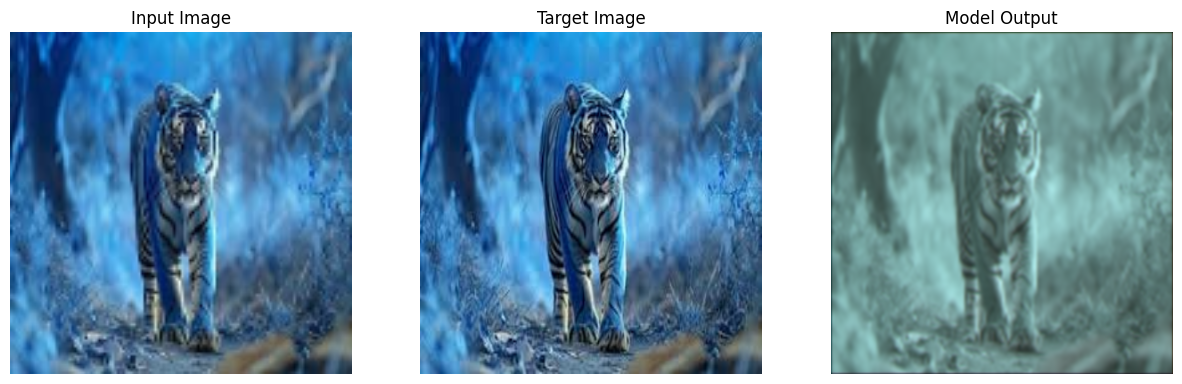

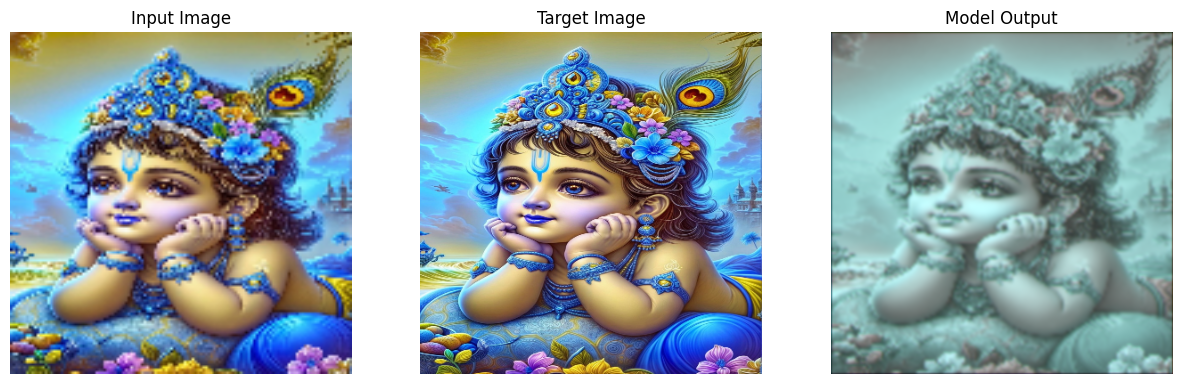

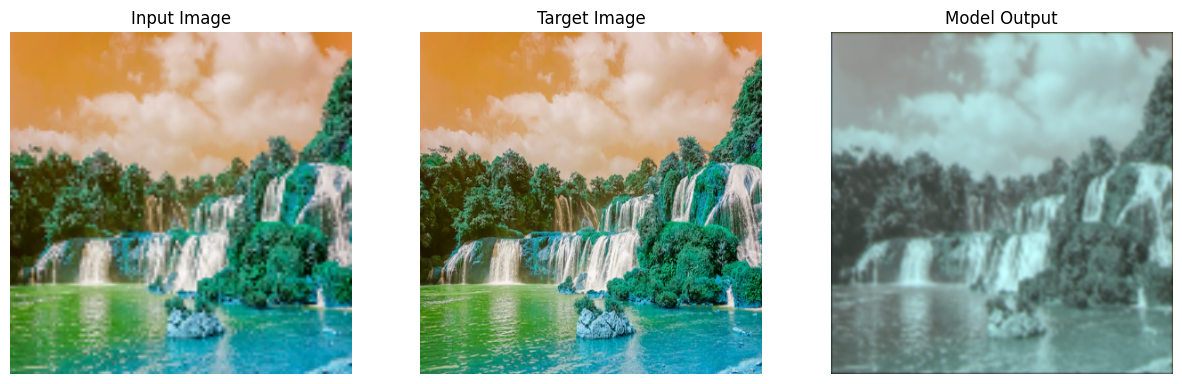

In [10]:
import matplotlib.pyplot as plt

student.eval()

# Iterate through a few batches
for i, (input_img, target_img) in enumerate(loader):
    if i >= 3:  # Display images for first 3 batches
        break

    input_img, target_img = input_img.to(device), target_img.to(device)
    with torch.no_grad():
        output = student(input_img)

    # Process each image in the batch
    for j in range(input_img.size(0)):
        input_np = input_img[j].permute(1, 2, 0).cpu().numpy()
        target_np = target_img[j].permute(1, 2, 0).cpu().numpy()
        output_np = output[j].permute(1, 2, 0).cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(input_np)
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        axes[1].imshow(target_np)
        axes[1].set_title("Target Image")
        axes[1].axis('off')

        axes[2].imshow(output_np)
        axes[2].set_title("Model Output")
        axes[2].axis('off')

        plt.show()

## Explore model improvements

### Subtask:
Suggest ways to potentially improve the model's performance, such as trying a different architecture, adjusting hyperparameters, or using a larger dataset.


## Summary:

### Data Analysis Key Findings

*   The model's performance was visually inspected by displaying sample input, target, and output images.
*   Potential areas for improving the model's performance include exploring different architectures (e.g., SRCNN, EDSR, RRDB), adjusting hyperparameters (learning rate, optimizer, epochs, batch size), using larger and more diverse datasets (e.g., ImageNet, DIV2K), and exploring alternative loss functions (perceptual losses, adversarial losses).

### Insights or Next Steps

*   The visual inspection provides a qualitative assessment of the model's output, complementing quantitative metrics like SSIM.
*   Implementing the suggested improvements could lead to a more robust model with better generalization capabilities and potentially higher performance metrics.


## Visualize results

### Subtask:
Display some of the input, target, and output images to visually inspect the model's performance.

**Reasoning**:
Display some of the input, target, and output images to visually inspect the model's performance.

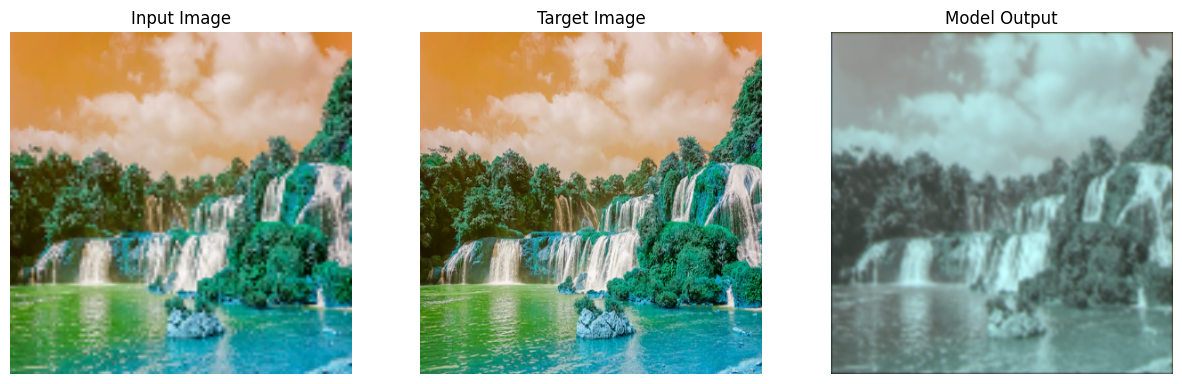

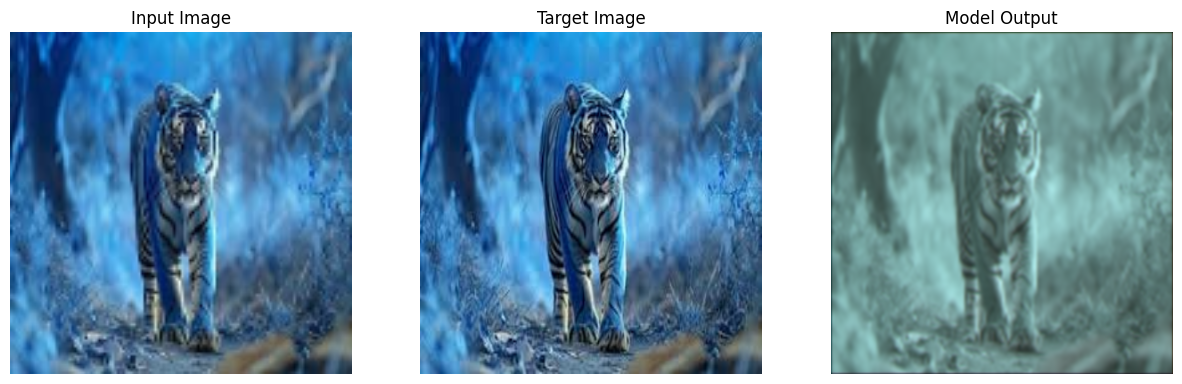

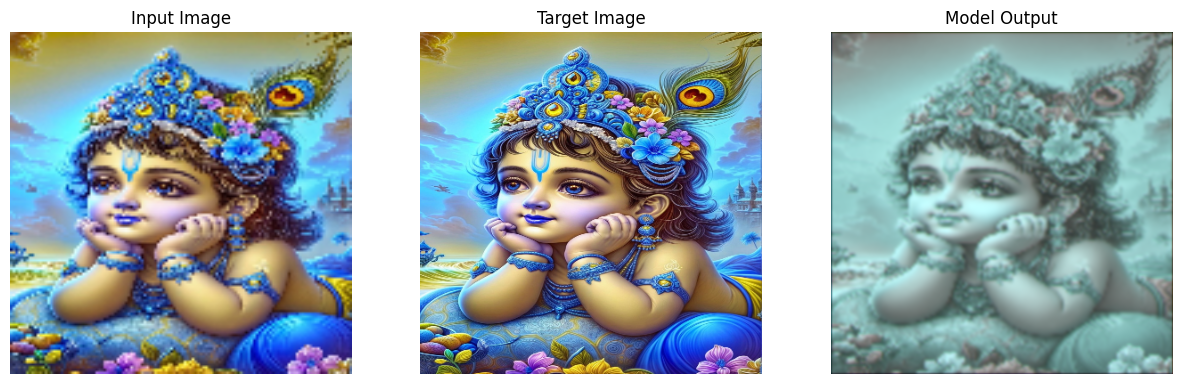

In [11]:
import matplotlib.pyplot as plt

student.eval()

# Iterate through a few batches
for i, (input_img, target_img) in enumerate(loader):
    if i >= 3:  # Display images for first 3 batches
        break

    input_img, target_img = input_img.to(device), target_img.to(device)
    with torch.no_grad():
        output = student(input_img)

    # Process each image in the batch
    for j in range(input_img.size(0)):
        input_np = input_img[j].permute(1, 2, 0).cpu().numpy()
        target_np = target_img[j].permute(1, 2, 0).cpu().numpy()
        output_np = output[j].permute(1, 2, 0).cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(input_np)
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        axes[1].imshow(target_np)
        axes[1].set_title("Target Image")
        axes[1].axis('off')

        axes[2].imshow(output_np)
        axes[2].set_title("Model Output")
        axes[2].axis('off')

        plt.show()

## Explore model improvements

### Subtask:
Suggest ways to potentially improve the model's performance, such as trying a different architecture, adjusting hyperparameters, or using a larger dataset.

## Summary:

### Data Analysis Key Findings

* The model's performance was visually inspected by displaying sample input, target, and output images.
* Potential areas for improving the model's performance include exploring different architectures (e.g., SRCNN, EDSR, RRDB), adjusting hyperparameters (learning rate, optimizer, epochs, batch size), using larger and more diverse datasets (e.g., ImageNet, DIV2K), and exploring alternative loss functions (perceptual losses, adversarial losses).

### Insights or Next Steps

* The visual inspection provides a qualitative assessment of the model's output, complementing quantitative metrics like SSIM.
* Implementing the suggested improvements could lead to a more robust model with better generalization capabilities and potentially higher performance metrics.